In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
# Reading the ratings data
ratings = pd.read_csv('Dataset/ratings.csv')

In [3]:
#len(ratings)
ratings.shape

(1048575, 4)

In [50]:
np.max

<function numpy.amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [4]:
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]
ratings.shape

(1048575, 3)

In [5]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [6]:
# In this case there are no such cases where the user has rated the same movie twice.
len(ratings_df)

1048575

In [7]:
# Inspecting the data
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [8]:
ratings_df.head()

rating
userId movieId        
1      2           3.5
       29          3.5
       32          3.5
       47          3.5
       50          3.5

In [9]:
# Counting no of unique users
len(ratings['userId'].unique())

7120

In [10]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [11]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,13232,13232,1.3
1.0,35144,35144,3.4
1.5,14029,14029,1.3
2.0,74706,74706,7.1
2.5,44791,44791,4.3
3.0,226202,226202,21.6
3.5,112926,112926,10.8
4.0,295135,295135,28.1
4.5,79848,79848,7.6


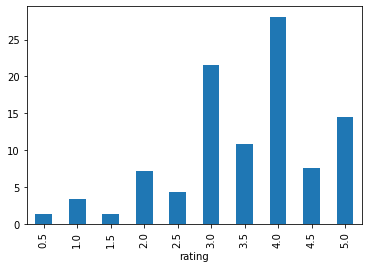

In [12]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [13]:
#reading the movies dataset
movie_list = pd.read_csv('Dataset/movies.csv')

In [14]:
len(movie_list)

27278

In [15]:
# insepcting the movie list dataframe
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# reading the tags datast
tags = pd.read_csv('Dataset/tags.csv')

In [17]:
# inspecting the tags data frame
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [18]:
# inspecting various genres
genres = movie_list['genres']

In [19]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [20]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Comedy',
 'Drama',
 'Film-Noir',
 '(no genres listed)',
 'Animation',
 'Documentary',
 'Mystery',
 'Horror',
 'Sci-Fi',
 'Adventure',
 'Thriller',
 'IMAX',
 'Fantasy',
 'Action',
 'Musical',
 'Children',
 'War',
 'Romance',
 'Crime',
 'Western']

In [21]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [22]:
movies_with_genres.head()

,movieId,title,genres,Comedy,Drama,Film-Noir,(no genres listed),Animation,Documentary,Mystery,...,Thriller,IMAX,Fantasy,Action,Musical,Children,War,Romance,Crime,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.99


In [24]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

14026

In [25]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [26]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [27]:
len(avg_movie_rating)

14026

In [28]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [29]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30 #30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [30]:
len(movie_score)

4173

In [31]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
#Calculating the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

<ipython-input-32-f069e78bacf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,mean,count,movieId,weighted_score
movieId,,,,
1,3.959323,2569,1,3.954359
2,3.268398,1155,2,3.275003
3,3.186861,685,3,3.201228
4,3.000000,138,4,3.094513
5,3.143836,657,5,3.160667


In [33]:
#join movie details to movie ratings
movie_score.index.name = None   # ajouté par HS
movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
#join movie links to movie ratings
#movie_score = pd.merge(movie_score,links,on='movieId')
#movie_score.head()
print(movie_score.shape)
print(movies_with_genres.shape)

(4173, 26)
(27278, 23)


In [34]:
movie_score.head()

,mean,count,movieId,weighted_score,title,genres,Comedy,Drama,Film-Noir,(no genres listed),...,Thriller,IMAX,Fantasy,Action,Musical,Children,War,Romance,Crime,Western
0,3.959323,2569,1,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,3.268398,1155,2,3.275003,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,3.186861,685,3,3.201228,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3.000000,138,4,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3.143836,657,5,3.160667,Father of the Bride Part II (1995),Comedy,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299,Crime|Drama
565,"Godfather, The (1972)",2137,4.388161,4.376270,Crime|Drama
46,"Usual Suspects, The (1995)",2490,4.370482,4.360468,Crime|Mystery|Thriller
403,Schindler's List (1993),2598,4.295612,4.286864,Drama|War
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037,Crime|Drama
3230,Band of Brothers (2001),228,4.353070,4.257280,Action|Drama|War
593,Casablanca (1942),1282,4.268721,4.251813,Drama|Romance
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151,Action|Adventure|Crime|Drama|Thriller
589,North by Northwest (1959),817,4.250306,4.224768,Action|Adventure|Mystery|Romance|Thriller
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788,Action|Crime|Drama|IMAX


In [36]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [37]:
#run function to return top recommended movies by genre
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
824,Duck Soup (1933),280,4.217857,4.151220
580,Singin' in the Rain (1952),542,4.097786,4.067969
3909,Dr. Horrible's Sing-Along Blog (2008),185,4.148649,4.062224
1777,Stop Making Sense (1984),119,4.142857,4.019316
2647,Fiddler on the Roof (1971),165,4.048485,3.968606
600,"Wizard of Oz, The (1939)",1229,3.947518,3.937552
588,"Gay Divorcee, The (1934)",57,4.149123,3.935381
1438,Nashville (1975),128,4.015625,3.923279
624,Top Hat (1935),120,4.004167,3.909188
3297,"Day at the Races, A (1937)",51,4.117647,3.899730


In [38]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
3230,Band of Brothers (2001),228,4.353070,4.257280
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
589,North by Northwest (1959),817,4.250306,4.224768
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
1838,Fight Club (1999),2085,4.219185,4.209399
769,Raiders of the Lost Ark (Indiana Jones and the...,2289,4.206204,4.197446
1256,Seven Samurai (Shichinin no samurai) (1954),594,4.223906,4.190510
199,Star Wars: Episode IV - A New Hope (1977),2874,4.189457,4.182637
1629,"Matrix, The (1999)",2705,4.176340,4.169242
768,"Princess Bride, The (1987)",1725,4.177391,4.166312


In [39]:
#run function to return top recommended movies by genre
best_movies_by_genre('Children',10)  

,title,count,mean,weighted_score
518,Wallace & Gromit: A Close Shave (1995),622,4.176045,4.146286
741,Wallace & Gromit: The Wrong Trousers (1993),798,4.133459,4.111568
793,"Grand Day Out with Wallace and Gromit, A (1989)",379,4.100264,4.058382
3833,WALL·E (2008),654,4.074159,4.050260
2927,My Neighbor Totoro (Tonari no Totoro) (1988),262,4.104962,4.045816
1753,"Christmas Story, A (1983)",686,4.035714,4.014495
3991,How to Train Your Dragon (2010),234,4.064103,4.003326
3931,Up (2009),502,4.030876,4.002591
4004,Toy Story 3 (2010),306,4.042484,3.996661
2989,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,183,4.046448,3.973606


In [40]:
#run function to return top recommended movies by genre
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299
565,"Godfather, The (1972)",2137,4.388161,4.376270
403,Schindler's List (1993),2598,4.295612,4.286864
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037
3230,Band of Brothers (2001),228,4.353070,4.257280
593,Casablanca (1942),1282,4.268721,4.251813
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
765,One Flew Over the Cuckoo's Nest (1975),1538,4.235696,4.222180
1838,Fight Club (1999),2085,4.219185,4.209399


In [41]:
# Creating a data frame that has user ratings accross all movies in form of matrix used in matrix factorisation
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max)

In [42]:
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    3.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN    4.0   
5          NaN    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 129350 129354 129428 129707 130052 130073 130219 130462 130490   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 130642  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 14026 columns]

In [46]:
ratings_df.to_numpy()

array([[nan, 3.5, nan, ..., nan, nan, nan],
       [nan, nan, 4. , ..., nan, nan, nan],
       [4. , nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [5. , nan, nan, ..., nan, nan, nan],
       [4.5, 4. , nan, ..., nan, nan, nan]])

In [49]:
# Apply low rank matrix factorization to find the latent features
U, M = matrix_factorization_utilities.low_rank_matrix_factorization(ratings_df.values,
                                                                    num_features=1,
                                                                    regularization_amount=1.0)

KeyboardInterrupt: 

In [ ]:
ratings_df

In [ ]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [ ]:
ratings_movies.head()

In [ ]:
ratings_movies

In [ ]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [ ]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

In [ ]:
from sklearn.neighbors import NearestNeighbors


In [ ]:
avg_movie_rating.head()

In [ ]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

In [ ]:
movie_plus_10_ratings

In [ ]:
movie_plus_10_ratings.index.name=None
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings, on="movieId")
len(filtered_ratings)

In [ ]:
filtered_ratings.head()

In [ ]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

In [ ]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)


In [ ]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movie_list.loc[movie_list['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movie_list.loc[movie_list['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [ ]:
print_similar_movies(112552)

In [ ]:
print_similar_movies(1)

In [ ]:
print_similar_movies(96079)

In [ ]:
movies_with_genres.head()

In [ ]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
movie_content_df = movie_content_df.as_matrix()
movie_content_df

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [ ]:
# Similarity of the movies based on the content
cosine_sim

In [ ]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

In [ ]:
#Gets the top 10 similar movies based on the content
def get_similar_movies_based_on_content(movie_index) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [ ]:
indicies["Skyfall (2012)"]

In [ ]:
get_similar_movies_based_on_content(19338)

In [ ]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()


In [ ]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

In [ ]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

In [ ]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

In [ ]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

In [ ]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

In [ ]:
pd.DataFrame(train_data_matrix).head()

In [ ]:
df_train['rating'].max()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [ ]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

In [ ]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

In [ ]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

In [ ]:
#choose a user ID
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

In [ ]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

In [ ]:
#count number of unique users
numUsers = df_train.userId.unique().shape[0]
#count number of unitque movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

In [ ]:
#Separate out the values of the df_train data set into separate variables
Users = df_train['userId'].values
Movies = df_train['movieId'].values
Ratings = df_train['rating'].values
print(Users),print(len(Users))
print(Movies),print(len(Movies))
print(Ratings),print(len(Ratings))

In [ ]:
#import libraries
import keras
from keras.layers import Embedding, Reshape  #Merge
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from keras.utils import plot_model

In [ ]:
# Couting no of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

In [ ]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [ ]:
# Splitting the data into train and test.
train, test = train_test_split(ratings, test_size=0.2)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
n_users, n_movies = len(ratings.userId.unique()), len(ratings.movieId.unique())
n_users

In [ ]:
# Returns a neural network model which performs matrix factorisation
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
    #prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    prod = keras.layers.dot([movie_vec, user_vec],axes=1)  # ajouté par HS
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [ ]:
model = matrix_factorisation_model_with_n_latent_factors(5)

In [ ]:
model.summary()

In [ ]:
#Training the model
history = model.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

In [ ]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

In [ ]:
#Getting summary of movie embeddings
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

In [ ]:
# Getting summary of user embeddings from the model
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

In [ ]:
from keras.constraints import non_neg

In [ ]:
# Returns a neural network model which performs matrix factorisation with additional constraint on embeddings(that they can't be negative)
def matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Non-Negative-Movie-Embedding',embeddings_constraint=non_neg())(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding',embeddings_constraint=non_neg())(user_input))
    #prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    prod = keras.layers.dot([movie_vec, user_vec],axes=1)  # ajouté par HS
    
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [ ]:
model2 = matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(5)

In [ ]:
model2.summary()

In [ ]:
history_nonneg = model2.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

In [ ]:
movie_embedding_learnt = model2.get_layer(name='Non-Negative-Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

In [ ]:
y_hat = np.round(model2.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [ ]:
mean_absolute_error(y_true, y_hat)

In [ ]:
# Returns a neural network model which does recommendation
def neural_network_model(n_latent_factors_user, n_latent_factors_movie):
    
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)


    #concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
    concat = keras.layers.concatenate([movie_vec, user_vec])
    
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

In [ ]:
model3 = neural_network_model(10,13)

In [ ]:
history_neural_network = model3.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

In [ ]:
model3.summary()

In [ ]:
y_hat = np.round(model3.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [ ]:
mean_absolute_error(y_true, y_hat)